In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import sys
import split_extract
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from multiprocessing import Pool
from params import dresden_images_root, images_db_path, patch_span, \
        patch_num, patches_root, patches_db_path

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./patches/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

Found 4875 images belonging to 3 classes.


In [5]:
print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)


# Evaluate on test data
77/77 [==============================] - 14s 183ms/step - loss: 0.1029 - accuracy: 0.9681
test loss, test acc: [0.10286879192360422, 0.9681367]


In [6]:
# Make predictions for the positive samples.
predictions = model.predict(test_generator)

pos_size = len(predictions)

num = pos_size // batch_size
test_generator.reset()
true_pos = 0

for i in range(num):
    label_batch = next(test_generator)[1]
    for j in range(batch_size):
        idx = np.argmax(predictions[i * batch_size + j])
        if (label_batch[j, idx] == 1):
            true_pos = true_pos + 1

accuracy = true_pos / pos_size

print("Test set accuracy: {:.3%}".format(accuracy))

In [7]:
images_db = np.load(images_db_path, allow_pickle=True).item()

model_list = np.unique(images_db['brand_model'])
img_list = images_db['path']
files_labels = dict(zip(images_db['path'], images_db['brand_model']))

img_path = np.random.choice(img_list, 1)[0]
img_brand_model = files_labels[img_path]
labels = [img_brand_model] * patch_num

In [8]:
img_name = os.path.join(dresden_images_root, img_path)
patches = split_extract.patchify(img_name, patch_span, pacth_size=(256, 256)).reshape((-1, 256, 256))

img_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
img_generator = img_gen.flow(np.expand_dims(patches, 3), labels, batch_size=25)

/home/pan/anaconda3/envs/cam/lib/python3.7/site-packages/skimage/util/shape.py:93: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


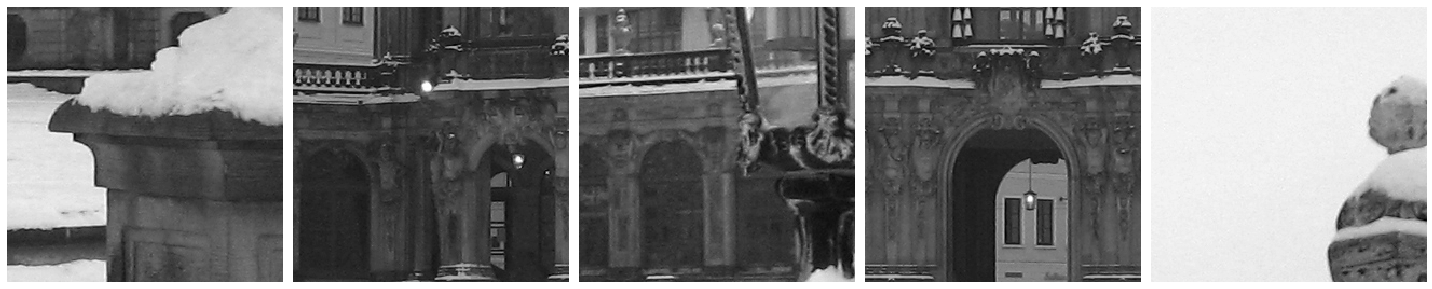

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(next(img_generator)[0][:5])

In [10]:
hist = [0, 0, 0]
pred = model.predict(img_generator)

for i in range(patch_num):
    label = np.argmax(pred[i])
    hist[label] += 1
    
print(model_list)
print(img_brand_model)
print(hist)

['Canon_Ixus55' 'Canon_Ixus70' 'Canon_PowerShotA640']
Canon_Ixus55
[23, 0, 2]
